# Visualising high-dimensional data

## Introduction

In this project I will explore a range of techniques for visualising very high dimensional datasets (which can be very challenging to understand). We will use the famous MNIST dataset of handwritten digit images which has 784 features per image.

The techniques we will use to explore this dataset will be:

- PCA (Principal components analysis)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)
- TDA (Topological data analysis)

These are different types of 'dimensionality reduction' techniques that aim to reduce down a datasets complexiy to a smaller number of dimensions (i.e. 2-3) while aiming to retain the maximum amount of variability in the dataset. We can then plot this 2/3 dimensional data on a 2d/3d scatter plot to make it easier to observe patterns visually in the data.

## Load libraries and view dataset

In [1]:
# Import libs
from __future__ import print_function
import time
import numpy as np
import pandas as pd
try:
    import umap
except ImportError:
    print("This example requires the UMAP library. You can install it with the command `!pip install umap-learn`")
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

try:
    from scipy.misc import imsave, toimage
except ImportError as e:
    print("imsave requires you to install pillow. Run `pip install pillow` and then try again.")
    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import kmapper as km
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import ipywidgets as ipw
import seaborn as sns

%matplotlib inline

imsave requires you to install pillow. Run `pip install pillow` and then try again.


In [2]:
# Load dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [3]:
# Convert feature matrix X and target vector y to a pandas dataframe.
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 786)


In [18]:
# For reproducability of the results
np.random.seed(42)
# Take random subset of digit images so we get a range of examples for each digit
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

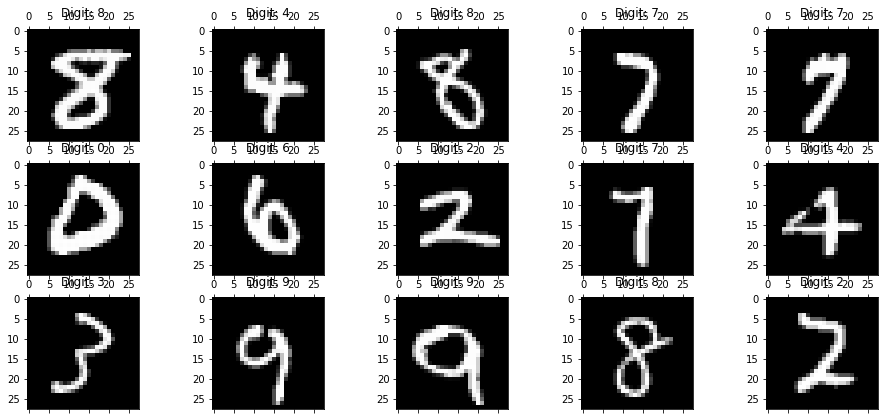

In [19]:
# Print examples
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

## Reduce dimensionality using PCA

Principal component analysis (PCA) is a technique used for identification of a smaller number of uncorrelated variables known as principal components from a larger set of data. The technique is widely used to emphasize variation and capture strong patterns in a data set.

In [6]:
# Extract first 3 principle components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


In [7]:
# Lets look at the dataset now - old features next to new PCA features
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel779,pixel780,pixel781,pixel782,pixel783,y,label,pca-one,pca-two,pca-three
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,5,122.252020,-316.214161,-51.103103
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1010.493916,-289.966402,576.104762
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,4,-58.996614,393.702308,-162.003086
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,-796.964627,-607.417888,295.511622
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9,9,-391.317982,729.791677,13.895489


The first 3 principle components account for around 23% of the variability in the whole dataset.

Is this variability enough to help us observe a difference between these new PCA features associated with each of the digits?

Let us create a 2d scatterplot of 2 of these new PCA features, and use a separate colour to group the data that relates to each of the digits, and see if we can see a separation between these points in these colour/digit groups.

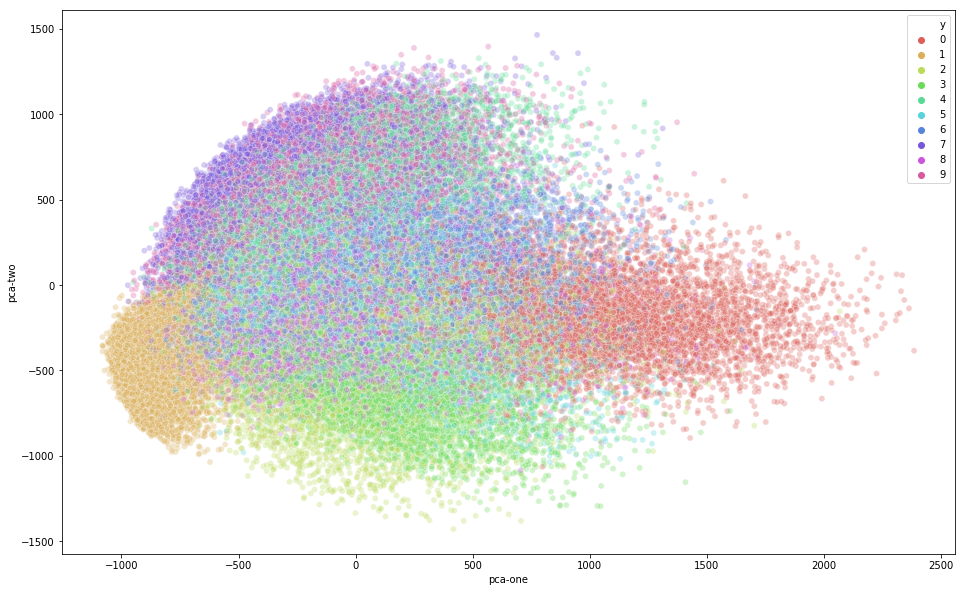

In [8]:
# Plot dataset with 2 PCA features, using same colour for data from each digit
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

We can see that even with 2 components, we can see a degree of separation between the data for each of the digits. However there is some overlap as well, so this is still not ideal for distinguishing the digits.

Lets see if we include all 3 PCA components if the separation is better, and we can plot this on a 3d scatterplot.

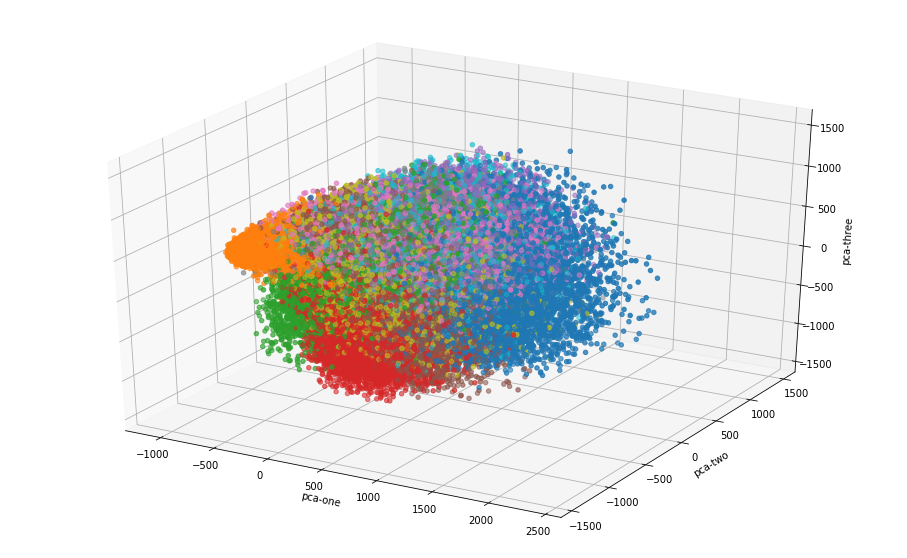

In [9]:
# Plot dataset with 3 PCA features, using same colour for data from each digit
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"].astype(int), 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

The separation between the digit data might be a little better, but there is still a high degree of overlap between the data for each of the digits.

## Reduce dimensionality using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

#### t-SNE vs PCA

What is the difference between t-SNE and PCA? PCA was developed much earlier (in 1933) whereas t-SNE was developed much more recently (in 2008) so much has changed in this time. t-SNE also differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance. This difference can potentially allow more of the varience to be preserved using t-SNE.

Let us first take a subset of the PCA transformed data which we will use later.

In [10]:
# Run PCA on subset
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09819946 0.07123677 0.06113222]


In [11]:
# Create 2 components using t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.027s...
[t-SNE] Computed neighbors for 10000 samples in 121.269s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 438.329018
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.188980
[t-SNE] KL divergence after 300 iterations: 2.830714
t-SNE done! Time elap

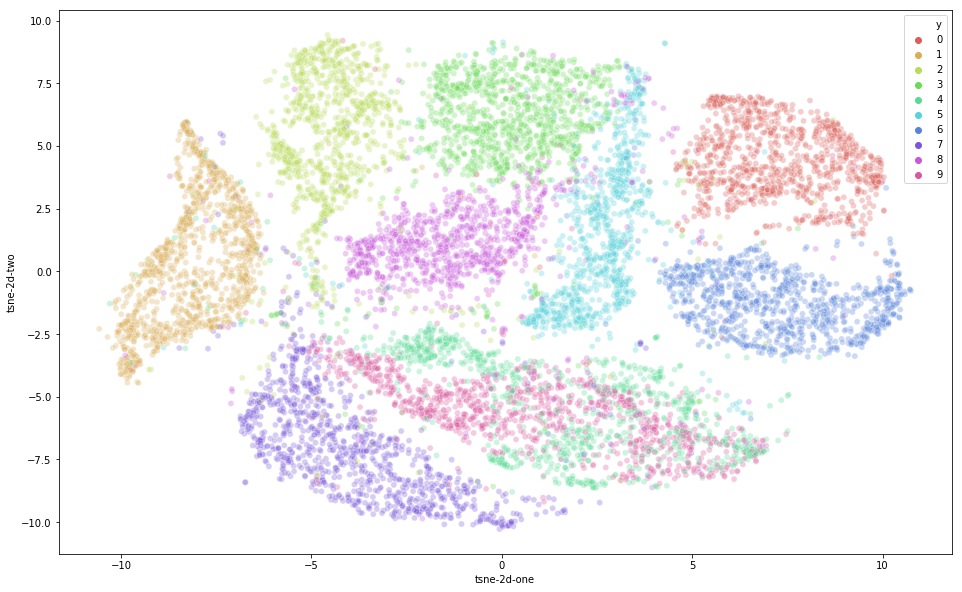

In [12]:
# Plot dataset with 2 t-SNE features, using same colour for data from each digit
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Here we can see a much nicer and clearer separation of the datapoints for each digit, clustered in their own sub-groups.

If we would now use a clustering algorithm to pick out the seperate clusters we could probably quite accurately assign new points to a label. 

Let's just compare side by side the PCA and t-SNE plots.

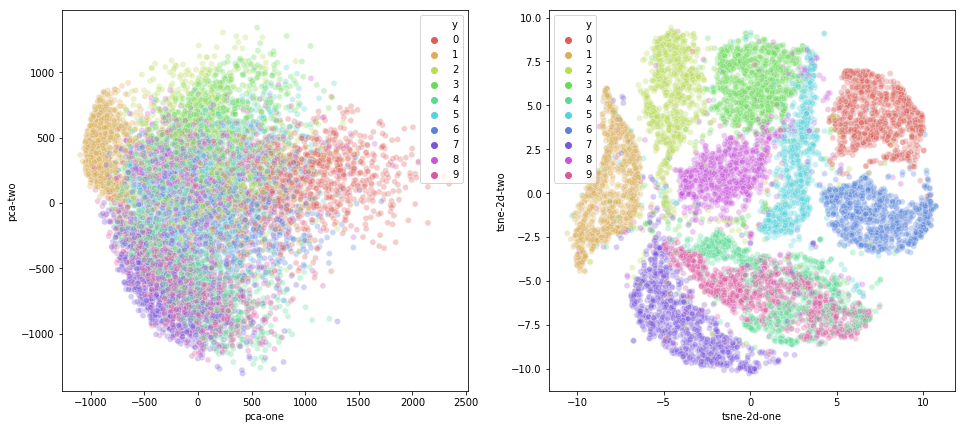

In [13]:
# Plot PCA and t-SNE datapoints side by side, coloured by digit
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

Lets try applying PCA first but with a higher number of components extracted, and then feed this into t-SNE

In [14]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.82616105907614


So it seems like the first 50 PCA components explain 82% of the varience.

Lets now take our reduced sample set to make sure its more easily computed to compare these different approaches so far.

In [15]:
# Apply t-SNE to enhanced PCA components
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 49.84275794029236 seconds


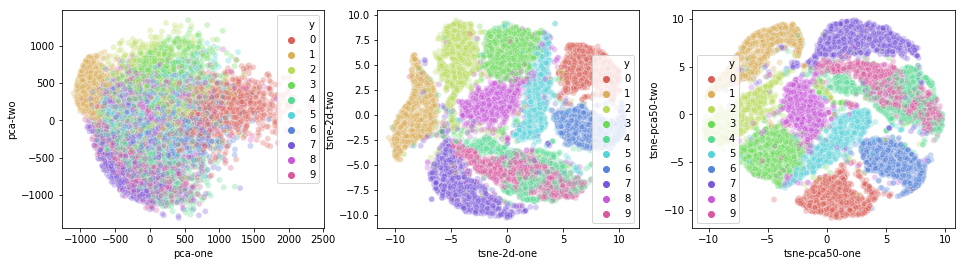

In [16]:
# Plot original PCA v original t-SNE v PCA+t-SNE
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

We can see how both the t-SNE and PCA enhanced t-SNE datasets have very nice groupings for the data for each digit, which could be very useful for example for any clustering or deep learning model for example.

## Reduce dimensionality using TDA

jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import sklearn
from sklearn import datasets
try:
    import umap
except ImportError:
    print("This example requires the UMAP library. You can install it with the command `!pip install umap-learn`")
import warnings
warnings.filterwarnings("ignore")

import kmapper as km
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import ipywidgets as ipw

data, labels = datasets.load_digits().data, datasets.load_digits().target
#Load the digits dataset
digits = datasets.load_digits()

print(data.size)
print(data[12].size)
print(data[12])
print(labels[12])

115008
64
[ 0.  0.  5. 12.  1.  0.  0.  0.  0.  0. 15. 14.  7.  0.  0.  0.  0.  0.
 13.  1. 12.  0.  0.  0.  0.  2. 10.  0. 14.  0.  0.  0.  0.  0.  2.  0.
 16.  1.  0.  0.  0.  0.  0.  6. 15.  0.  0.  0.  0.  0.  9. 16. 15.  9.
  8.  2.  0.  0.  3. 11.  8. 13. 12.  4.]
2


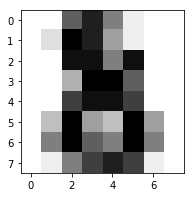

In [39]:
#Display the first digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [40]:
mapper = km.KeplerMapper(verbose=0)

#projected_data = mapper.fit_transform(data, projection=umap.UMAP(n_neighbors=8,
projected_data = mapper.fit_transform(df[feat_cols].values, projection=umap.UMAP(n_neighbors=8,
                                                                 min_dist=0.65,
                                                                 n_components=2,
                                                                 metric='euclidean',
                                                                 random_state=3571))

# Get the simplicial complex  
scomplex = mapper.map(projected_data,
                      clusterer=sklearn.cluster.DBSCAN(eps=0.3, min_samples=15),
                      cover=km.Cover(35, 0.9))

In [41]:
color_function = projected_data[:, 1]-projected_data[:, 1].min()
plotlyviz(scomplex, 
          title='Mapper graph of digits dataset',
          color_function=color_function, 
          color_function_name='Distance to y-min', 
          node_linecolor='rgb(100,100,100)',
          bgcolor='rgb(240,240,240)',
          width=620, height=620,
          summary_height=350,
          summary_left=10,
          hist_left=25,
          hist_right=10,
          graph_data=True)

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [30]:
color_function = projected_data[:, 1]-projected_data[:, 1].min()
plotlyviz(scomplex, 
          title='Mapper graph of digits dataset',
          color_function=color_function, 
          color_function_name='Distance to y-min', 
          node_linecolor='rgb(100,100,100)',
          bgcolor='rgb(240,240,240)',
          width=620, height=620,
          summary_height=350,
          summary_left=10,
          hist_left=25,
          hist_right=10,
          member_textbox_width=500,
          dashboard=True)

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [ ]:
#test